In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import sys
from IPython.display import display

In [2]:
def on_kaggle() -> bool:
    try:
        import gresearch_crypto
        return True
    except ModuleNotFoundError:
        return False

In [3]:
# HYPER PARAMETERS
ON_KAGGLE = on_kaggle()
SAMPLE_LEVEL = 1
USE_SAMPLE = SAMPLE_LEVEL == 1
USE_TOY_SAMPLE = SAMPLE_LEVEL == 2

FORCE_REWRITE = (ON_KAGGLE and SAMPLE_LEVEL == 0)

In [4]:
if not ON_KAGGLE and os.path.abspath('.').endswith('notebook'):
    os.chdir('../')

In [5]:
#IMPORT_SCRIPT!
# THIS CELL WILL BE REMOVE WITH SCRIPTS IN SRC
if './src/' not in sys.path:
    sys.path.append('./src')

from preprocessing import *
from metrics import *

In [6]:
if ON_KAGGLE:
    RAW_DIR = Path('../input/g-research-crypto-forecasting/')
    SAMPLE_DIR = Path('../input/create-sample-dataset/data/raw/sample/')
    TOY_SAMPLE_DIR = Path('../input/create-sample-dataset/data/raw/toy_sample/')
else:
    RAW_DIR =  Path('data/raw')
    TOY_SAMPLE_DIR = RAW_DIR.joinpath('toy_sample')
    SAMPLE_DIR = RAW_DIR.joinpath('sample')

# filename
TRAIN_FILE = 'train.csv'
ASSET_DETAILS_PATH = RAW_DIR / 'asset_details.csv'

In [7]:
if USE_TOY_SAMPLE:
    print('USING TOY DATASET')
    RAW_TRAIN_PATH = TOY_SAMPLE_DIR / TRAIN_FILE

elif USE_SAMPLE:
    print('USING SAMPLE DATASET')
    RAW_TRAIN_PATH = SAMPLE_DIR / TRAIN_FILE

else:
    print('USING RAW DATASET')
    RAW_TRAIN_PATH = RAW_DIR / TRAIN_FILE

assert RAW_TRAIN_PATH.exists()

USING SAMPLE DATASET


In [8]:
!ls {RAW_DIR}

asset_details.csv		   sample
example_sample_submission.csv	   supplemental_train.csv
example_test.csv		   toy_sample
g-research-crypto-forecasting.zip  train.csv
gresearch_crypto


In [9]:
%%time 
raw_df = pd.read_csv(RAW_TRAIN_PATH)

CPU times: user 7.25 s, sys: 538 ms, total: 7.79 s
Wall time: 7.78 s


In [10]:
raw_df = ingest_data(raw_df, asset_details_path=ASSET_DETAILS_PATH)

In [11]:
raw_df.sort_values(by=['Asset_ID', 'time'], inplace=True)
raw_df.reset_index(drop=True, inplace=True)

In [12]:
raw_df.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Asset_Name,time
0,1609459260,0,219.0,37.384998,37.422100,37.348701,37.389000,2749.5692,37.387058,-0.001669,Binance Coin,2021-01-01 00:01:00
1,1609459320,0,133.0,37.390499,37.402000,37.329800,37.331299,778.8680,37.351677,-0.001542,Binance Coin,2021-01-01 00:02:00
2,1609459380,0,151.0,37.317051,37.336700,37.272900,37.291500,890.9210,37.301258,-0.001028,Binance Coin,2021-01-01 00:03:00
3,1609459440,0,123.0,37.299149,37.323002,37.250198,37.291901,489.9361,37.297272,0.000174,Binance Coin,2021-01-01 00:04:00
4,1609459500,0,623.0,37.212799,37.285000,37.104801,37.213001,15144.3836,37.184082,0.000950,Binance Coin,2021-01-01 00:05:00


In [13]:
TARGET = 'Target'
INDEX_COLS = ['Asset_ID', 'Asset_Name', 'time', 'timestamp']

In [14]:
FEATURES = list(raw_df.columns.drop(INDEX_COLS + [TARGET]))

### current min features

In [180]:
from typing import List, Callable, Dict
from scipy.stats import linregress
RAW_FEATURES = ['Count', 'Open', 'High', 'Low', 'Close',
                'Volume', 'VWAP']


def log_return(x: pd.Series, periods: int = 1):
    return np.log(x).diff(periods=periods).fillna(0)

def compute_current_features(df: pd.DataFrame) -> pd.DataFrame:
    df['high_low_return'] = np.log(df['High'] / df['Low']) # is it better to take the log or not?
    df['open_close_return'] = np.log(df['Close'] / df['Open'])
    
    df['upper_shadow'] = df['High'] - np.maximum(df['Close'], df['Open'])
    df['lower_shador'] = np.minimum(df['Close'], df['Open']) - df['Low']
    
    df['log_return'] = log_return(df['Close'])
        
    return df

def realized_volatility(series: pd.Series):
    if not isinstance(series, np.ndarray):
        series = series.to_numpy()
    return np.sqrt(np.sum(np.power(series, 2)))


def linear_slope(series: pd.Series) -> float:
    linreg = linregress(np.arange(len(series)), series)
    return linreg.slope

FEATURE_DICT = {'Open': [np.mean],
                'High': [np.max],
                'Low': [np.min],
                'log_return': [np.sum, realized_volatility],
                'Count': [np.sum, np.max],
                'Volume': [np.sum, np.max]
               }

def join_columns(columns):
    return list(map(lambda f: '__'.join(map(str, f)), columns))


class ComputeHistoryFeatures:
    def __init__(self, feature_dict: Dict[str, List[Callable]],
                 windows: int = List[str]):
        self.feature_dict = feature_dict
        self.windows = windows
    
    def train(self, X: pd.DataFrame, n: int = True):
        features = X.rolling(n).agg(self.feature_dict)
        return features

    def inference(self, X: pd.DataFrame, n: int):
        features = X.tail(n).agg(self.feature_dict)
        features = features.stack().to_frame().T
        features.columns = features.columns.swaplevel(0, 1)
        return features
    
    def __call__(self, X: pd.DataFrame, inference: bool = False):
        func = self.inference if inference else self.train
        output = []
        for n in self.windows:
            features = func(X, n)
            features.columns = join_columns(features.columns)
            output.append(features.add_suffix(f'__{n}min'))
        return pd.concat(output, axis=1)
            

In [181]:
X = raw_df.query('Asset_ID==0').reset_index(drop=True)
X = compute_current_features(X)

In [182]:
X = raw_df.query('Asset_ID==0').reset_index(drop=True)
X = compute_current_features(X)

In [183]:
cpter = ComputeHistoryFeatures(FEATURE_DICT, [60])

In [186]:
%%timeit -n 10
output = cpter(X, inference=True)

15.8 ms ± 3.65 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
raw_df = compute_current_features(raw_df)

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

In [21]:
RAW_FEATURES = ['Count', 'Open', 'High', 'Low', 'Close',
       'Volume', 'VWAP']

In [22]:
models = {}
scores = []
for crypto, crypto_data in raw_df.groupby('Asset_Name'):
    print(crypto)
    model = Pipeline([('norm', StandardScaler()), 
                      ('model', LogisticRegression())])
    model.fit(crypto_data[RAW_FEATURES], crypto_data['profit'])
    models[crypto] = model['model']
    acc = (model.predict(crypto_data[RAW_FEATURES]) == crypto_data['profit']).mean()
    print(acc)
    scores.append(acc)
print('mean')
print(np.mean(scores))

Binance Coin
0.5052222286792014
Bitcoin
0.523190506745249
Bitcoin Cash
0.5257151306947059
Cardano
0.5202173700651423
Dogecoin
0.5287371800965388
EOS.IO
0.5245596894721555
Ethereum
0.5125743316750636
Ethereum Classic
0.5227960475936478
IOTA
0.5128609034877205
Litecoin
0.5261850127670586
Maker
0.5135799662120183
Monero
0.5093108320458477
Stellar
0.5290935016239339
TRON
0.5104792435192936
mean
0.5188944246198269


In [23]:
coef = pd.concat([pd.DataFrame({'Asset_Name': asset, 'feature': RAW_FEATURES, 'coef': model.coef_[0]})
                  for asset, model in models.items()])

In [24]:
coef_table = coef.pivot('Asset_Name', 'feature', 'coef').T

In [25]:
coef_table

Asset_Name,Binance Coin,Bitcoin,Bitcoin Cash,Cardano,Dogecoin,EOS.IO,Ethereum,Ethereum Classic,IOTA,Litecoin,Maker,Monero,Stellar,TRON
feature,,,,,,,,,,,,,,
Close,-0.008493,-2.222588,-1.623174,-1.581826,-1.901188,-2.196243,0.000081,-0.070069,-0.015902,-2.454465,0.204142,-0.129163,-1.765433,-0.004397
Count,0.041619,-0.122230,-0.027268,0.002841,-0.003612,-0.033368,-0.010469,-0.013953,-0.005213,-0.029824,0.006346,-0.019836,0.000267,-0.017271
High,-0.008286,2.375967,-0.069333,-1.685318,0.067970,-0.438663,0.000969,0.194935,-0.151646,-1.799407,-0.904229,1.621348,0.287825,-0.004950
Low,-0.007779,-1.861434,-0.339702,-2.438010,-0.932070,-0.326130,0.000808,-0.074986,0.137821,0.532967,0.308772,-1.721531,-1.118553,-0.004157
Open,-0.007326,2.204851,2.187360,5.055958,3.161888,3.334857,0.001833,-0.025721,-0.007426,3.622232,0.203135,0.243880,2.832520,-0.004588
VWAP,-0.008059,-0.541236,-0.159510,0.639813,-0.405263,-0.380294,0.000921,-0.060030,-0.010134,0.081696,0.163462,-0.027886,-0.251255,-0.004493
Volume,-0.028058,0.076645,0.027297,0.034503,0.027498,0.021982,0.020279,0.022049,0.003245,0.025210,0.001486,-0.017207,-0.010682,-0.003895


In [26]:
coef.groupby('feature').describe()

coef                                                              \
        count      mean       std       min       25%       50%       75%   
feature                                                                     
Close    14.0 -0.983480  1.044335 -2.454465 -1.867249 -0.855495 -0.010345   
Count    14.0 -0.016569  0.035798 -0.122230 -0.025410 -0.012211 -0.000703   
High     14.0 -0.036630  1.091815 -1.799407 -0.366908 -0.006618  0.163193   
Low      14.0 -0.560285  0.908227 -2.438010 -1.071932 -0.200558 -0.000434   
Open     14.0  1.628818  1.763520 -0.025721 -0.002983  1.215620  3.079546   
VWAP     14.0 -0.068733  0.287102 -0.541236 -0.228319 -0.019010 -0.000433   
Volume   14.0  0.014311  0.026225 -0.028058 -0.002550  0.021131  0.026775   

                   
              max  
feature            
Close    0.204142  
Count    0.041619  
High     2.375967  
Low      0.532967  
Open     5.055958  
VWAP     0.639813  
Volume   0.076645

In [27]:
# lets visualize this relationships

In [28]:
raw_df['open_close_range'] = np.log(raw_df['Close'] / raw_df['Open'])
raw_df['high_low_return'] = np.log(raw_df['High'] / raw_df['Low'])

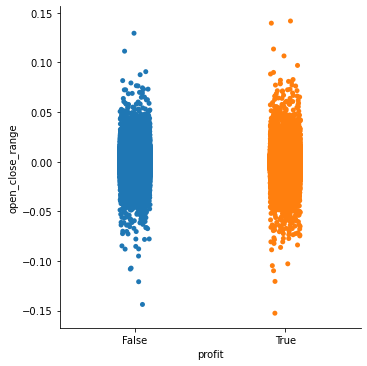

In [34]:
sns.catplot(x='profit', y='open_close_range', data=raw_df)

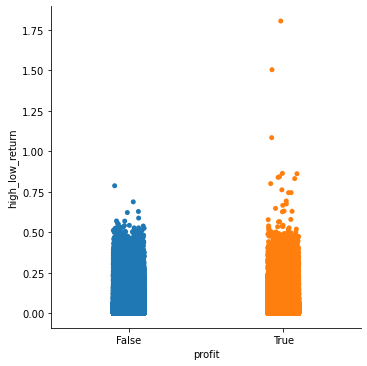

In [36]:
sns.catplot(x='profit', y='high_low_return', data=raw_df)

## gen features

In [16]:
raw_df[FEATURES]

,Count,Open,High,Low,Close,Volume,VWAP
0,219.0,37.384998,37.422100,37.348701,37.389000,2.749569e+03,37.387058
1,133.0,37.390499,37.402000,37.329800,37.331299,7.788680e+02,37.351677
2,151.0,37.317051,37.336700,37.272900,37.291500,8.909210e+02,37.301258
3,123.0,37.299149,37.323002,37.250198,37.291901,4.899361e+02,37.297272
4,623.0,37.212799,37.285000,37.104801,37.213001,1.514438e+04,37.184082
...,...,...,...,...,...,...,...
5300890,477.0,0.091435,0.091500,0.091120,0.091221,2.613704e+06,0.091340
5300891,980.0,0.091131,0.091195,0.090802,0.090863,4.991573e+06,0.090991
5300892,720.0,0.090853,0.090940,0.090740,0.090859,3.699102e+06,0.090838
5300893,686.0,0.090941,0.091450,0.090860,0.091326,3.241507e+06,0.091193


In [17]:
def compute_current_features(df: pd.DataFrame) -> pd.DataFrame:
    df['high_low_range'] = (df['High'] - df['Low'])
    df['open_close_range'] = (df['Close'] - df['Open'])
    
    df['upper_shadow'] = df['High'] - np.maximum(df['Close'], df['Open'])
    df['lower_shador'] = np.minimum(df['Close'], df['Open']) - df['Low']
        
    return df

In [85]:
cfeat = compute_current_features(raw_df.copy())

In [86]:
CURRENT_FEATURES = list(cfeat.columns.drop(INDEX_COLS + [TARGET]))

In [87]:
FEAT = 'Volume'

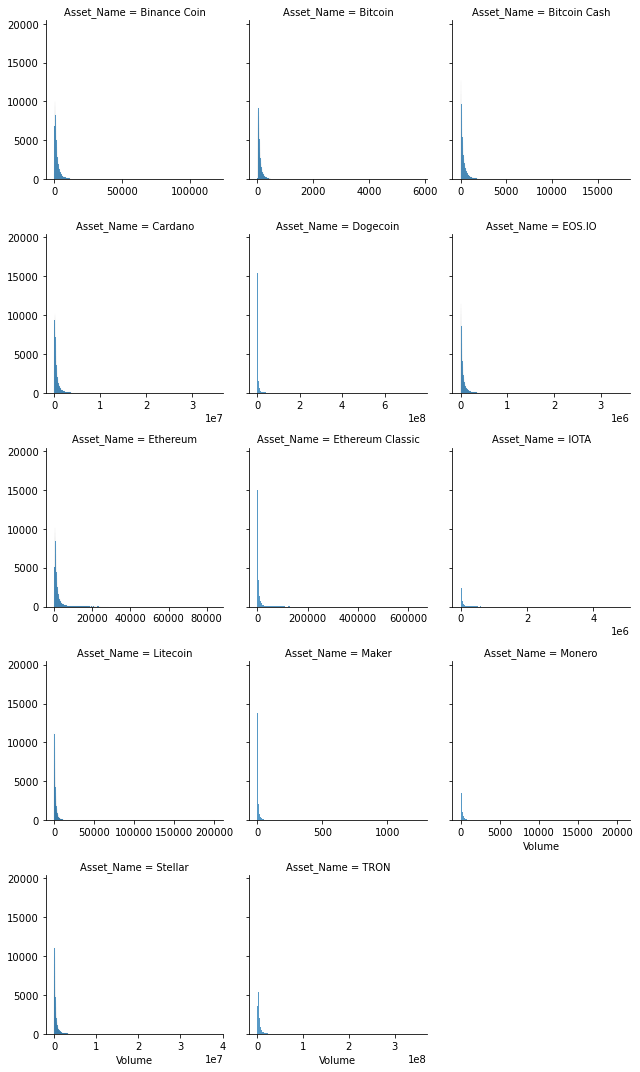

In [88]:
g = sns.FacetGrid(cfeat, col='Asset_Name', col_wrap=3,
                  sharex=False)
g.map(sns.histplot, FEAT)

scales are way too diferent, we should scale by crypto to normalize the effect of the model

In [89]:
from sklearn.preprocessing import quantile_transform, minmax_scale, scale
def quantile_transform_1d(x):
    return quantile_transform(x.to_numpy()[:, None], random_state=1, output_distribution='normal').ravel()

In [90]:
norm_feat = cfeat[[FEAT, 'Asset_Name']]

In [91]:
norm_feat['min_max'] = norm_feat.groupby('Asset_Name')[FEAT].transform(minmax_scale)
norm_feat['scale'] = norm_feat.groupby('Asset_Name')[FEAT].transform(scale)
norm_feat['qt'] = norm_feat.groupby('Asset_Name')[FEAT].transform(quantile_transform_1d)

/home/med/anaconda3/envs/crypto-g/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/med/anaconda3/envs/crypto-g/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/med/anaconda3/envs/crypto-g/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [93]:
_x = norm_feat.query("Asset_Name == 'TRON'")
assert np.allclose(_x['scale'], scale(_x[FEAT]))
assert np.allclose(_x['min_max'], minmax_scale(_x[FEAT]))
assert np.allclose(_x['qt'], quantile_transform_1d(_x[FEAT]))

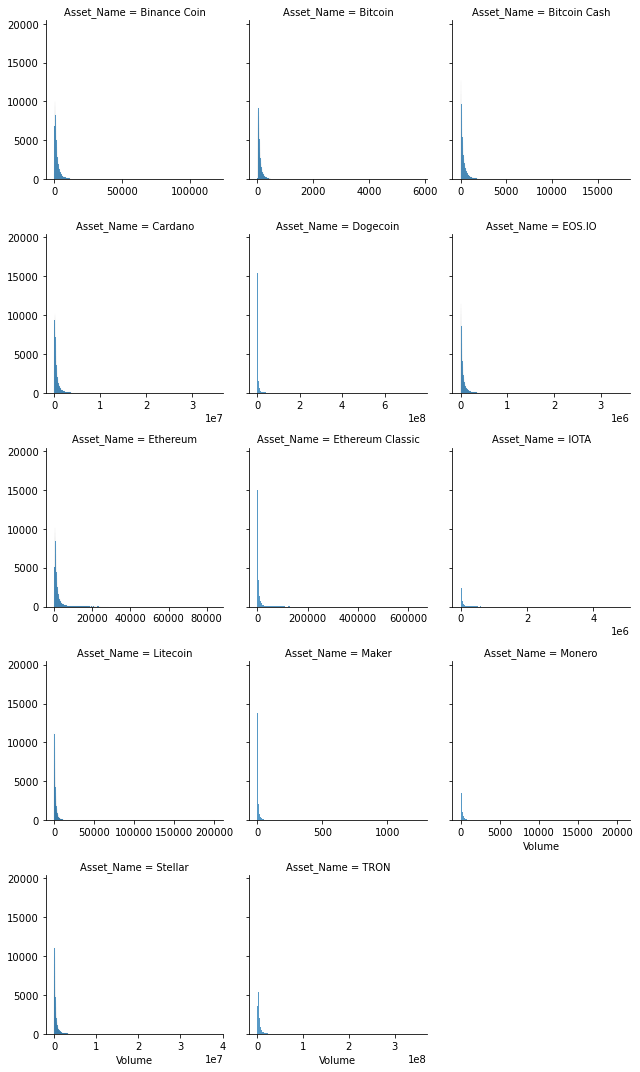

In [94]:
g = sns.FacetGrid(norm_feat, col='Asset_Name', col_wrap=3,
                  sharex=False)
g.map(sns.histplot, FEAT)

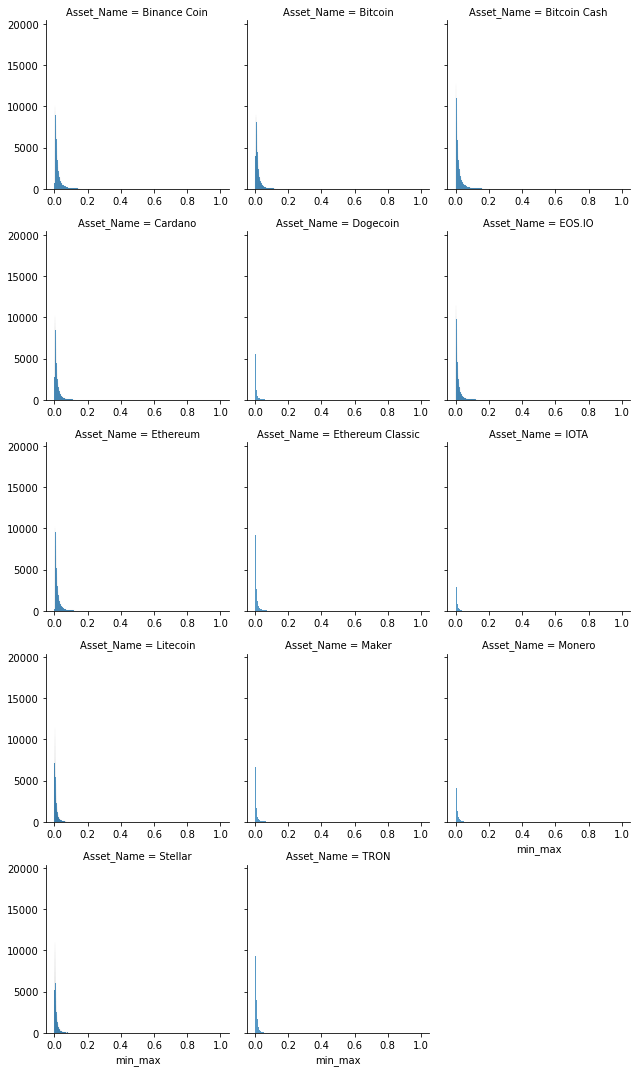

In [95]:
g = sns.FacetGrid(norm_feat, col='Asset_Name', col_wrap=3,
                  sharex=False)
g.map(sns.histplot, 'min_max')

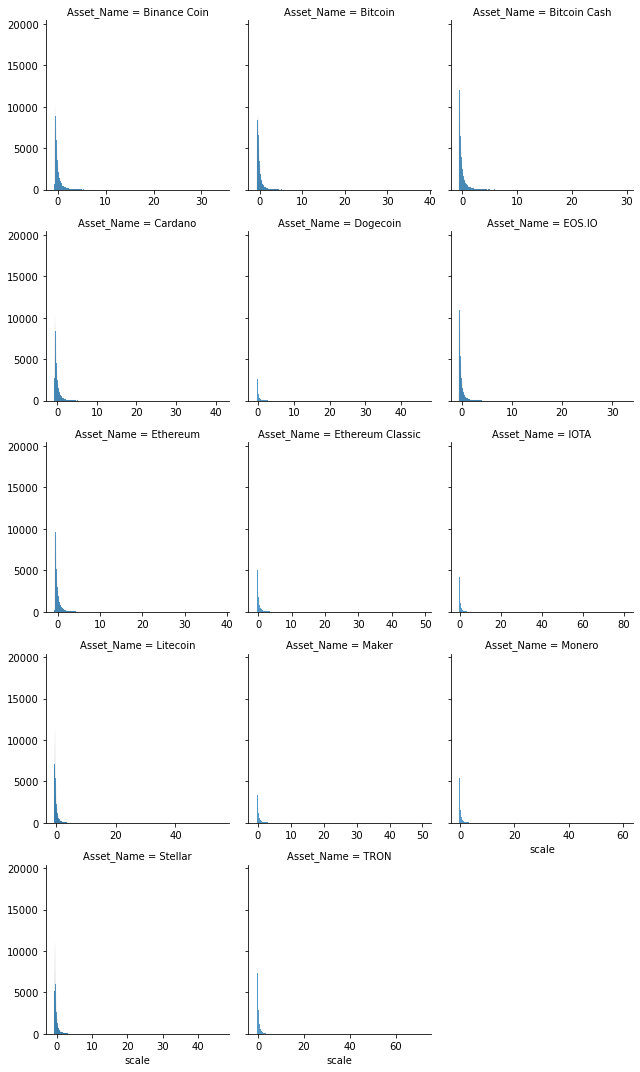

In [96]:
g = sns.FacetGrid(norm_feat, col='Asset_Name', col_wrap=3,
                  sharex=False)
g.map(sns.histplot, 'scale')

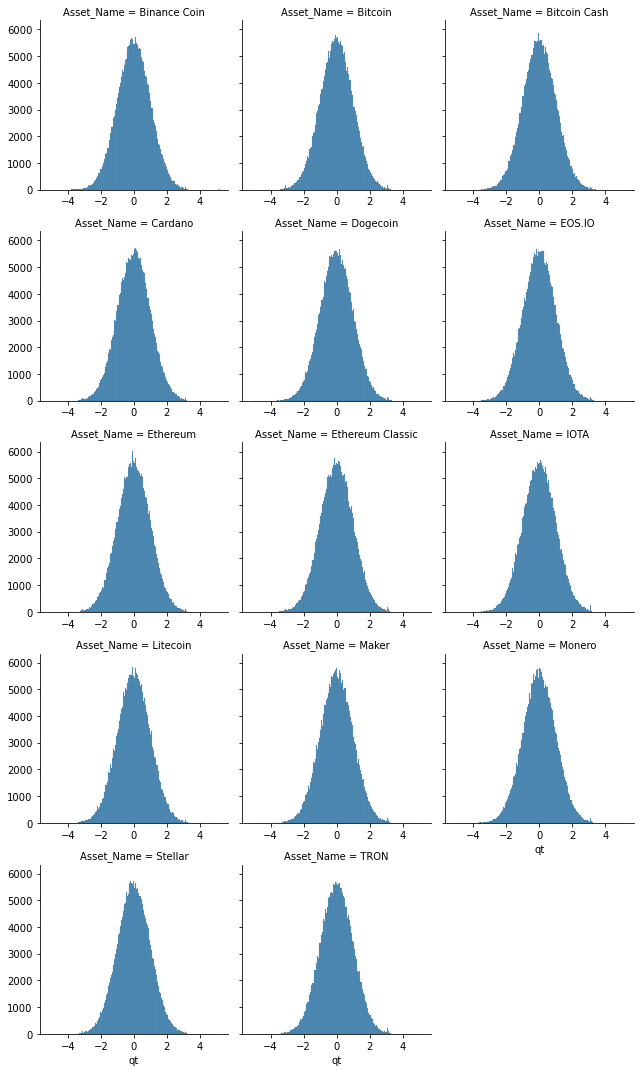

In [97]:
g = sns.FacetGrid(norm_feat, col='Asset_Name', col_wrap=3,
                  sharex=False)
g.map(sns.histplot, 'qt')

how does this will help us for modeling? we will figure out tomorrow baby

## time dependance 

In [16]:
### daily pattern

In [17]:
## date attr

raw_df['hour'] = raw_df['time'].dt.hour
raw_df['dayofweek'] = raw_df['time'].dt.dayofweek
raw_df['month'] = raw_df['time'].dt.month
raw_df['year'] = raw_df['time'].dt.year

In [18]:
### hour pattern

<AxesSubplot:xlabel='hour', ylabel='Target'>

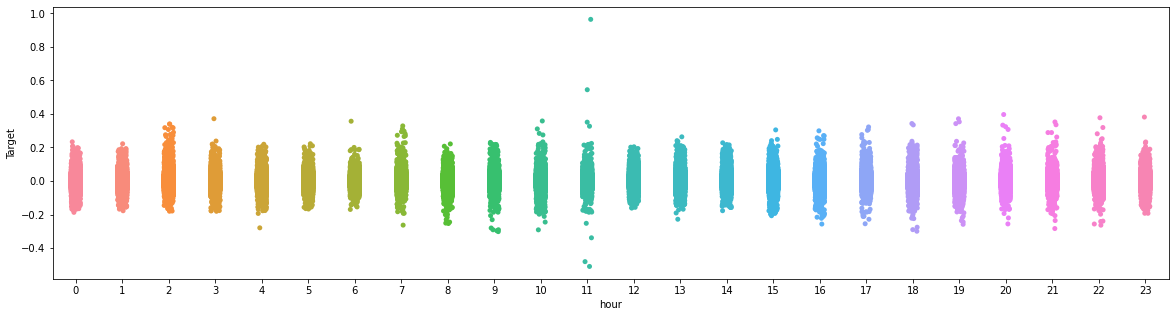

In [19]:
plt.figure(figsize=(20, 5))
sns.stripplot(x='hour', y='Target', data=raw_df)

/home/med/anaconda3/envs/crypto-g/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


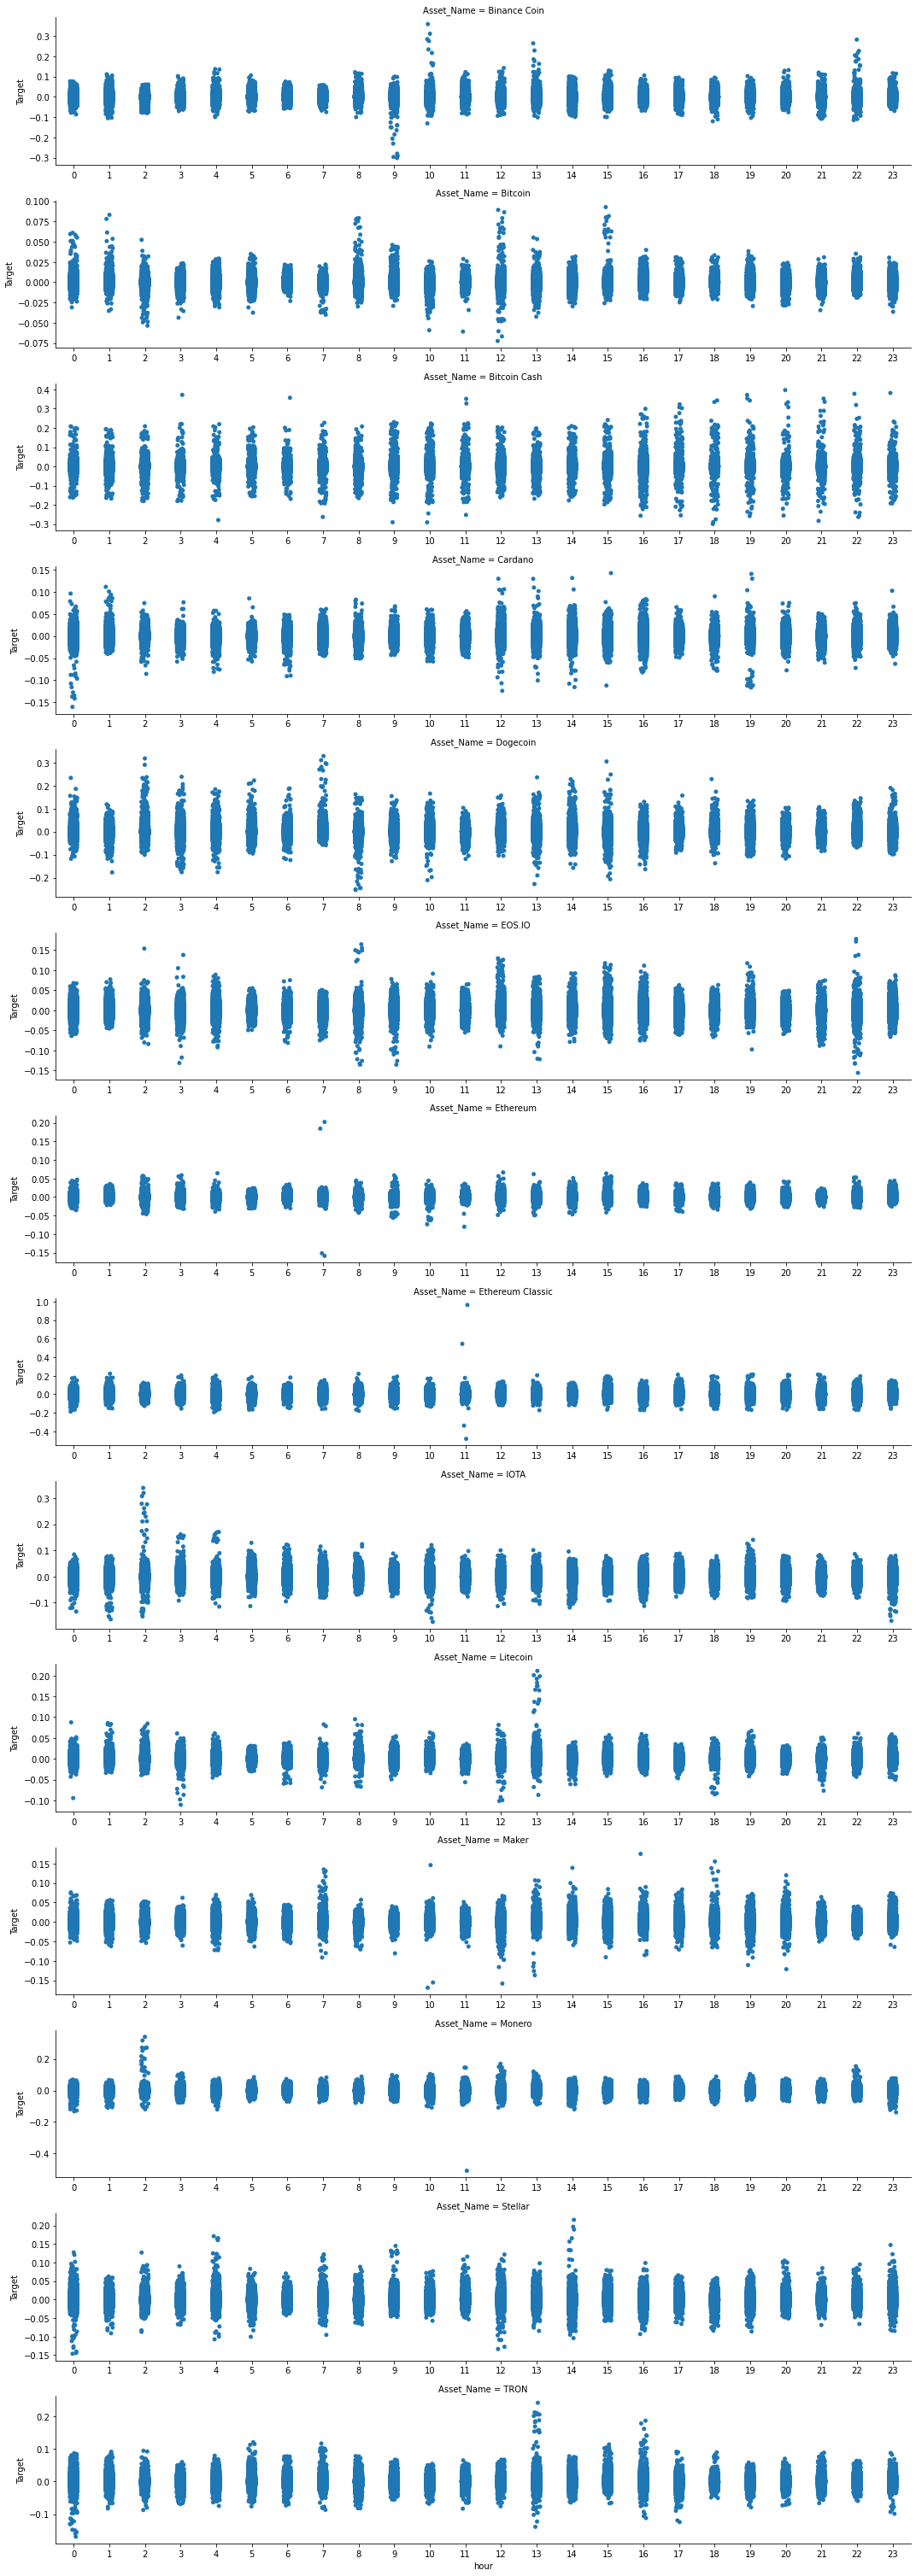

In [20]:
g = sns.FacetGrid(raw_df, row='Asset_Name', aspect=5, sharey=False)
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True, labelleft=True)
g.map(sns.stripplot, 'hour', 'Target')

it seems most volatile hours are the mid day 

<AxesSubplot:xlabel='dayofweek', ylabel='Target'>

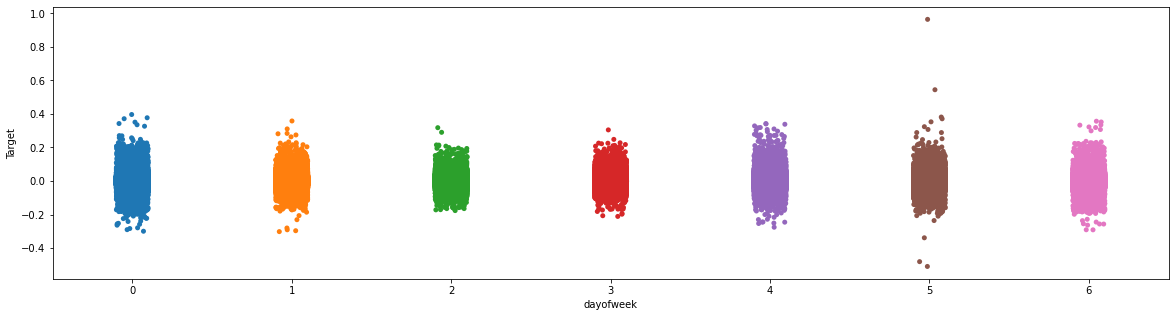

In [20]:
plt.figure(figsize=(20, 5))
sns.stripplot(x='dayofweek', y='Target', data=raw_df)

/home/med/anaconda3/envs/crypto-g/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


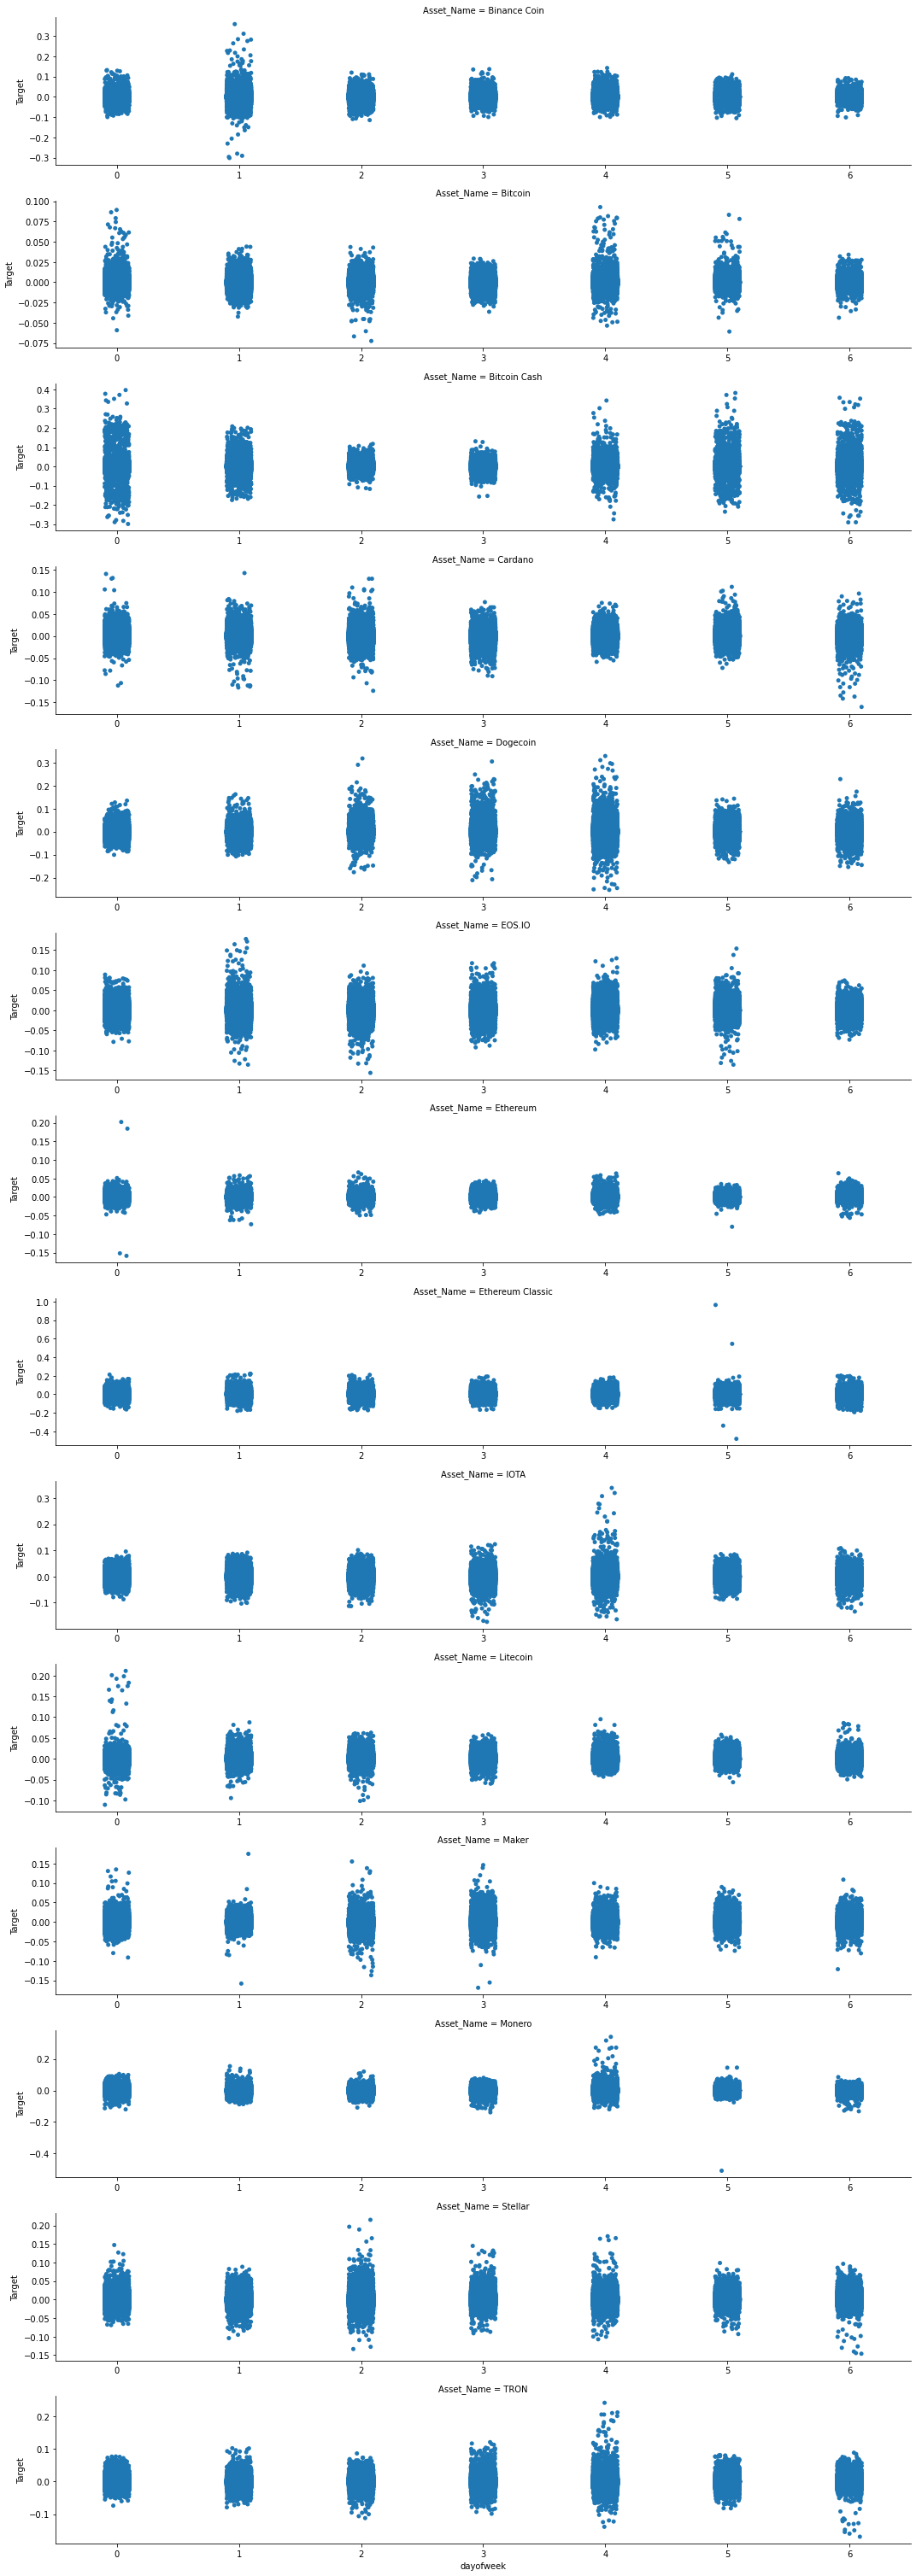

In [21]:
g = sns.FacetGrid(raw_df, row='Asset_Name', aspect=5, sharey=False)
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True, labelleft=True)
g.map(sns.stripplot, 'dayofweek', 'Target')

In [ ]:
daily_agg = raw_df.groupby(['dayofweek', 'hour'])['Target'].apply(lambda s: np.sqrt(np.square(s).sum()))
daily_agg_table = daily_agg.unstack()

In [ ]:
plt.figure(figsize=(20, 5))
sns.heatmap(daily_agg_table, annot=True)

<AxesSubplot:xlabel='month', ylabel='Target'>

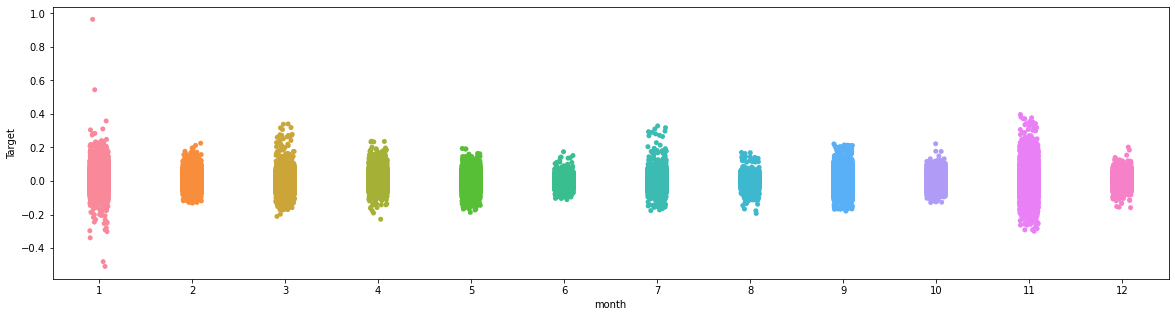

In [27]:
plt.figure(figsize=(20, 5))
sns.stripplot(x='month', y='Target', data=raw_df)

## looking at time series

In [15]:
top_returns = raw_df.dropna()
top_returns[TARGET + '_abs'] = np.abs(top_returns[TARGET])
top_returns = top_returns.sort_values(by=TARGET + '_abs', ascending=False)

/home/med/anaconda3/envs/crypto-g/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
top_returns['_date'] = pd.to_datetime(top_returns['time'].dt.date)

In [75]:
top_days = top_returns[['_date', 'Asset_Name']].drop_duplicates()

In [76]:
top_days.head(20)

,_date,Asset_Name
1554489,2021-01-28,Dogecoin
1555539,2021-01-29,Dogecoin
4963329,2021-01-29,TRON
1666031,2021-04-16,Dogecoin
1559018,2021-01-31,Dogecoin
1564110,2021-02-04,Dogecoin
3775885,2021-09-13,Litecoin
2830303,2021-05-05,Ethereum Classic
2831916,2021-05-06,Ethereum Classic
1683551,2021-04-28,Dogecoin


In [80]:
def plot_day(day, asset_name, feature1='Target',feature2='Target', ax=None):
    if ax is None:
        f, ax = plt.subplots(figsize=(20, 5))
    X = top_returns.query('_date == @day and Asset_Name == @asset_name')
    X = X.sort_values(by='timestamp')
    twinx = ax.twinx()
    X['xaxis'] =(X['timestamp'] - X['timestamp'].min())// 60
    sns.lineplot(data=X, x='xaxis', y=feature1, ax=ax)
    sns.lineplot(data=X, x='xaxis', y=feature2, ax=twinx, color='darkorange')

In [92]:
day, asset_name = '2021-05-05', 'Ethereum Classic'

In [128]:
X = top_returns.query('_date == @day and Asset_Name == @asset_name')
X = X.sort_values(by='timestamp')
X['xaxis'] =(X['timestamp'] - X['timestamp'].min())// 60

In [129]:
X['Open'] = X['Open'] / X['Open'].iloc[0]

<AxesSubplot:xlabel='xaxis', ylabel='Open'>

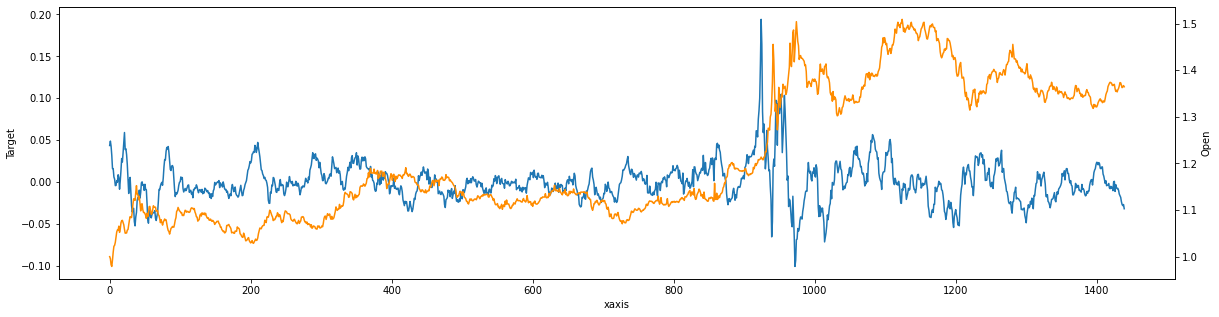

In [132]:
f, ax = plt.subplots(figsize=(20, 5))
twinx = ax.twinx()

sns.lineplot(data=X, x='xaxis', y='Target', ax=ax)
sns.lineplot(data=X, x='xaxis', y='Open', ax=twinx, color='darkorange')

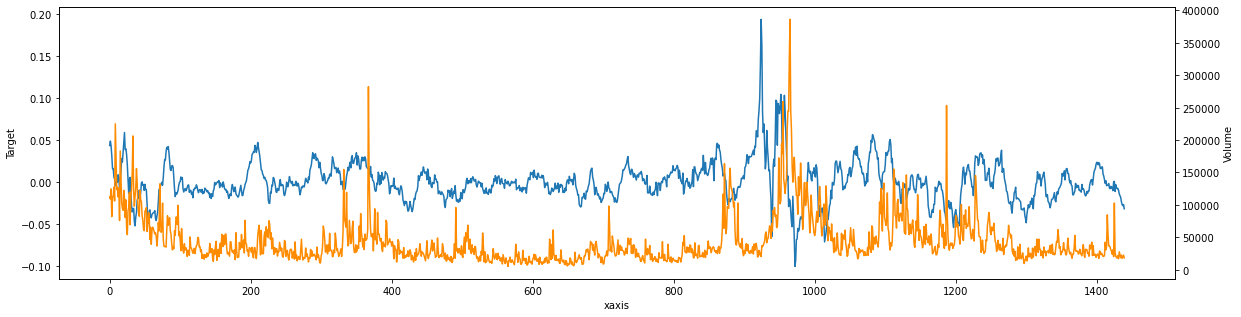

In [86]:
plot_day(day, asset_name, feature2='Volume')

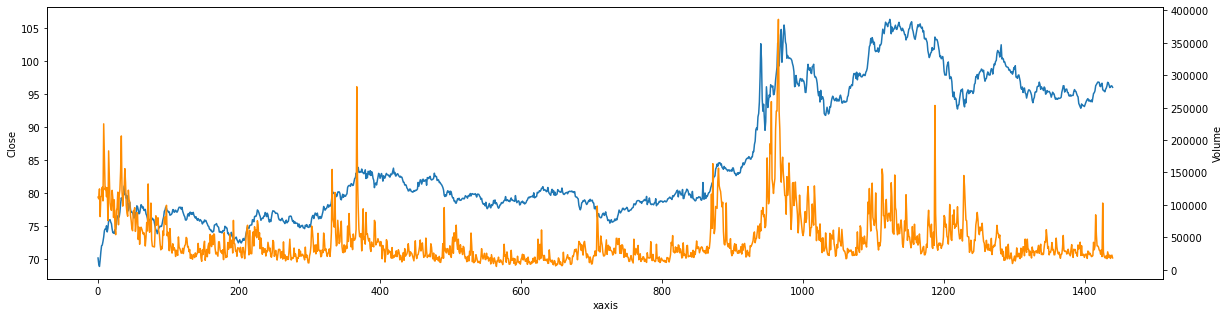

In [85]:
plot_day(day, asset_name, feature1='Close', feature2='Volume')